# Sembradora 3000

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [55]:
# Model design
import agentpy as ap
import networkx as nx 
import random
import numpy as np
from collections import deque
from queue import PriorityQueue

# Visualization
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import IPython
from IPython.display import HTML

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

In [68]:
"""
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""


def is_connected(grid, free_positions):
    """ Check if all free cells are connected using BFS """
    n = grid.shape[0]
    visited = set()
    queue = deque([free_positions.pop()])
    visited.add(queue[0])

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    connected_count = 1
    free_count = len(free_positions)

    while queue:
        x, y = queue.popleft()
        for dx, dy in directions:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < n and 0 <= new_y < n and (new_x, new_y) in free_positions and (new_x, new_y) not in visited:
                queue.append((new_x, new_y))
                visited.add((new_x, new_y))
                connected_count += 1
        
                
    return connected_count > free_count

def generate_grid(model, n, obstacles_count):
    grid = ap.Grid(model, (n, n), track_empty=True)  # Create an agentpy Grid object
    grid.add_field("occupied", 0)  # Add a field to store obstacle information

    # Generate obstacle positions
    obstacle_positions = set()
    while len(obstacle_positions) < obstacles_count:
        x, y = random.randint(0, n-1), random.randint(0, n-1)
        if (x, y) not in obstacle_positions and (x,y) not in model.p.seedsPositions:
            obstacle_positions.add((x, y))

    # Mark grid cells as obstacles
    for pos in obstacle_positions:
        grid["occupied"][pos] = 1

    # Identify free positions
    free_positions = set()
    for pos in grid.all:
        if grid["occupied"][pos] != 1:
            free_positions.add(pos)

    # Check if the free cells are connected
    final_obstacles = set()
    while not is_connected(grid, free_positions):
        final_obstacles.clear()
        grid = ap.Grid(model, (n, n), track_empty=True)
        grid.add_field("occupied", 0)
        obstacle_positions = set()
        while len(obstacle_positions) < obstacles_count:
            x, y = random.randint(0, n-1), random.randint(0, n-1)
            if (x, y) not in obstacle_positions and (x,y) not in model.p.seedsPositions:
                obstacle_positions.add((x, y))
        
        free_positions = set()
        for pos in grid.all:
            if grid["occupied"][pos] == 0:
                free_positions.add(pos)
        final_obstacles = obstacle_positions

    for pos in obstacle_positions:
        grid["occupied"][pos] = 1
        model.np_grid[pos] = 3
    #add an agent to each obstacle position with type 2
    #Make an agentlist ap.agentlist
    #Add the agent to the grid
    #Add the agent to the agentlist
    agentlist = ap.AgentList(model, len(obstacle_positions))
    agentlist.type = 2
        
    grid.add_agents(agentlist, obstacle_positions)
    


    model.grid = grid

class CollectingTractor(ap.Agent):
    def setup(self, type = 1, pos = (0,0)):
        self.collected = 0
        self.targetIndex = 1
        self.path = []
        self.destroyed = False
        self.condition = True
        self.seeds = 0
        self.type = type
        self.pos = pos
        self.start = pos


    def heuristic(x1, y1, x2, y2):
        return abs(x1 - x2) + abs(y1 - y2)
    
    def a_star_search(self, start, end):
        #initialize the frontier using the initial state of the problem
        frontier = PriorityQueue()
        frontier.put(start, 0)
        came_from = {}
        cost_so_far = {}
        came_from[start] = None
        cost_so_far[start] = 0

        #run the search
        while not frontier.empty():
            current = frontier.get()

            if current == end:
                break

            #add to negihbors all the neighbors of the current cell
            neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            size = self.model.grid.shape[0]

            for nextTemp in neighbors:
                #check if the next cell is within the grid
                next = (current[0]+ nextTemp[0], current[1] + nextTemp[1])
                if next[0] < 0 or next[0] >= size or next[1] < 0 or next[1] >= size:
                    continue
                #check if the next cell is an obstacle
                if self.model.grid["occupied"][next] == 1:
                    continue

                new_cost = cost_so_far[current] + 1
                if next not in cost_so_far or new_cost < cost_so_far[next]:
                    cost_so_far[next] = new_cost
                    priority = new_cost + abs(end[0] - next[0]) + abs(end[1] - next[1])
                    frontier.put(next, priority)
                    came_from[next] = current

        #reconstruct the path
        path = []
        current = end
        while current != start:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path
        
    def collect(self):
        #run an A* search to find the shortest path to the target
        if (self.type == 2):
            return

        if (self.destroyed):
            return


        start = (self.pos[0], self.pos[1])
        if (self.seeds > 0):
            end = self.targets[self.targetIndex]
        else:
            #iterate through the seeds and find the closest one using A*
            minDist = 100000
            for seed in self.model.p.seedsPositions:
                dist = len(self.a_star_search(start, seed))
                if (dist < minDist):
                    minDist = dist
                    end = seed

        self.model.np_grid[end] = 2
        if (len(self.path) == 0):
            self.path = self.a_star_search(start, end)

        
        if (len(self.path) == 0):
            next_pos = self.pos
        else:
            next_pos = self.path.pop(0)
            if not (next_pos in self.model.grid.empty.items):
                return        
        
        self.model.grid.move_to(self, next_pos)
        self.model.np_grid[self.pos] = 0
        self.model.np_grid[next_pos] = 1
        self.pos = next_pos

        if (self.pos in self.model.p.seedsPositions):
            self.seeds = self.capacity
            return
        #check if the target has been reached

        if self.pos == end:
            self.seeds -= 1
            self.model.Collected += 1
            self.targetIndex += 1
            if self.targetIndex == len(self.targets):
                self.model.np_grid[self.pos] = 0
                self.model.grid.remove_agents(self)
                self.destroyed = True
                self.condition = False
                self.type = 0
    


In [69]:


class TractorModel(ap.Model):
    def setup(self):
        self.Collected = 0
        #numpy array of size grid_size x grid_size
        self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))
        generate_grid(self, self.p.grid_size, self.p.obstacles_count)
        #Create p.number_of_tractors tractors
        self.agents = ap.AgentList(self, self.p.number_of_tractors, CollectingTractor)
        self.agents.capacity = self.p.capacity
        self.agents.seeds = self.p.starting_seeds
        #Set the targets for each tractor, checking that they are not obstacles
        for tractor in self.agents:
            targets = []
            for i in range(self.p.number_of_targets):
                x, y = random.randint(0, self.p.grid_size-1), random.randint(0, self.p.grid_size-1)
                while self.grid["occupied"][(x, y)] == 1:
                    x, y = random.randint(0, self.p.grid_size-1), random.randint(0, self.p.grid_size-1)
                targets.append((x, y))
            tractor.targets = targets
            tractor.pos = targets[0]
            self.np_grid[tractor.pos] = 1
        
        self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])
            
        
    def update(self):
        self.record('Collected', sum([tractor.collected for tractor in self.agents]))

        
    def step(self):
        self.agents.collect()
        #Assign 4 to the seed positions
        for seed in self.p.seedsPositions:
            self.np_grid[seed] = 4
        
    def end(self):
        self.report('Total targets', self.p.number_of_targets * self.p.number_of_tractors)
        
        #time to collect all targets


## Running a simulation

In [74]:


tractorParameters = {
    'grid_size': 100,
    'obstacles_count': 10,
    'number_of_tractors': 4,
    'number_of_targets': 10,
    'steps': 500,
    'seedsPositions': [(0, 0)],
    'capacity': 2,
    'starting_seeds': 2
}

model = TractorModel(tractorParameters)
results = model.run(steps=50)
'''model = VirusModel(parameters)
results = model.run() '''

C:\Users\andy5\AppData\Local\Temp\ipykernel_25164\925827101.py:35: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grid.add_field("occupied", 0)  # Add a field to store obstacle information


Completed: 50 steps
Run time: 0:00:00.777256
Simulation finished


'model = VirusModel(parameters)\nresults = model.run() '

## Analyzing results

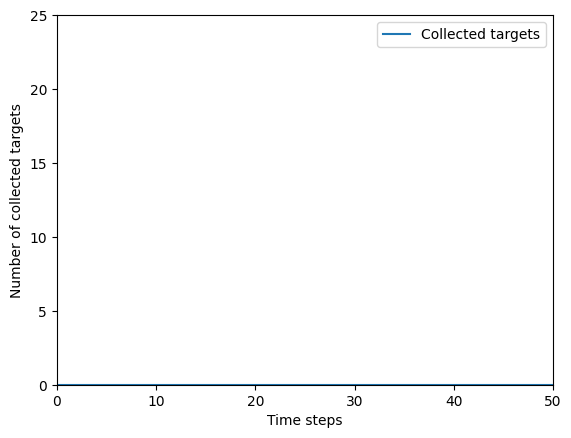

In [75]:
def tractor_plot(data, ax):
    x = data.index.get_level_values('t')
    y = data['Collected']
    ax.plot(x, y, label='Collected targets')
    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 25)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Number of collected targets")

fig, ax = plt.subplots()
tractor_plot(results.variables.TractorModel, ax)

## Creating an animation

In [76]:
"""
0 is empty
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""
def animation_plot(model, ax):
    # Define a custom colormap using the specified colors
    cmap = mcolors.ListedColormap(['white', 'blue', 'yellow', 'red', 'green'])

    # Define the bounds and create a norm
    bounds = [0, 1, 2, 3, 4, 5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Clear the axis to avoid over-plotting
    ax.clear()

    # Plot the grid using the custom colormap
    ap.gridplot(model.np_grid, cmap=cmap, norm=norm, ax=ax)

    # Add text for each tractor displaying the number of seeds it has
    

    # Set the title for the plot
    ax.set_title(f"Tractor model \n Time-step: {model.t}, "
                 f"Collected: {model.Collected}")
    
    for agent in model.agents:
        if (agent.destroyed):
            continue
        ax.text(agent.pos[1], agent.pos[0], str(agent.seeds),
                color='black', fontsize=12, ha='center', va='center', weight='bold')

# Example usage
fig, ax = plt.subplots()
model = TractorModel(tractorParameters)
animation = ap.animate(model, fig, ax, animation_plot)
animation.save('simulacionTractores.gif')




C:\Users\andy5\AppData\Local\Temp\ipykernel_25164\925827101.py:35: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grid.add_field("occupied", 0)  # Add a field to store obstacle information
MovieWriter ffmpeg unavailable; using Pillow instead.


In [77]:
#Display the animation
HTML(animation.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available